# Evaluating the impact of HISP: Regression Discountinuity Designs (RDD)

In the design of HISP, the authorities tageted the program to low-income households using <b>the national poverty line</b>. The poverty line isbased on a poverty index that assigns each household in the country a score between 20 and 100 based on its assets, housing conditions, and sociodemographic structure. <b>The poverty line has been officially set at 58</b>. This means that all households with a score of 58 or below are classified as poor, and all households with a score of more than 58 are considered to be nonpoor. Even in the treatment villages, only poor households are eligible to enroll in HISP.

We will conduct 4 steps to measure HISP with RDD:

* Step 1: Check data eligibility
* Step 2: Apply RDD
* Step 3: Set RDD robustness check point
* Step 4: Estimate treatment effect

# Set up

### Lauching stata from the jupyter notebook

In [5]:
%%capture
import stata_setup
import os
os.chdir('C:\Program Files\Stata17/utilities')
from pystata import config
config.init('mp');

### Initial set up of log file and load data

In [6]:
%%capture
%%stata

clear
set more off, perm

# redirect to workplace
cd "C:\Users\USER\Desktop\Charlene\2022 Charlene at York\Evaluation of Health Policy\practical exercise"

# load data
use "evaluation.dta", clear

# limit sample to the cross section of post-treatment data
drop if round==0

### Create(rename) variable for treatment effect evaluation 

In [7]:
%%capture
%%stata

# create generic variable (y)
clonevar y=health_expenditures 
label var y "out of pocket health expenditure pc/pa"
clonevar d=enrolled 
label var d "Treatment"

# create potential outcome y0 and y1
clonevar y0=y 
replace y0=. if d==1
clonevar y1=y 
replace y1=. if d==0

# summarise outcome of the treated and control group
bysort d:summ y y0 y1
tabstat y y0 y1, by(d)

# Create global list of regressors
global xs "age_hh age_sp educ_hh educ_sp female_hh indigenous hhsize dirtfloor bathroom land hospital_distance" 

## Step1: Check Data Eligibility

Before carrying out the regression doscountinuity design estimations, we shall check the data eligibility bt answering:
* Whether there there is any evidence of <b>manupulation of the eligibility index</b>?
* Whether <b>households respected their assignment to the treatment</b> and comparison groups on the basis of their eligibility score?

To answer the first question, I plot the percentage of househols against the baseline poverty index (figure 1). The figure does not indicate any "bunching" of households right below the cutoff of 58. 

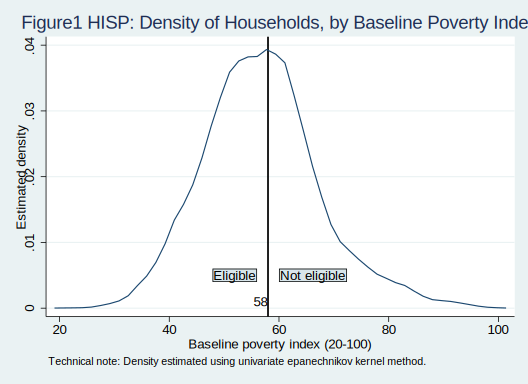

In [8]:
%%stata
kdensity poverty_index, title("Figure1 HISP: Density of Households, by Baseline Poverty Index") ytitle("Estimated density") xtitle("Baseline poverty index (20-100)") note("Technical note: Density estimated using univariate epanechnikov kernel method.") xline(58, lcolor(black) lwidth(medthick)) text(.005 60 "Not eligible", placement(e) box) text(.005 56 "Eligible", placement(w) box) text( 0 58 "58", placement(nw))

Next, to answer the second question, I plot participation in the program against the baseline poverty index (figure 2). Figure 2 shown that two years after the start of the pilot, only households with a score of 58 or below (that is, to the left of the poverty line) have been allowed to enroll in HISP. In addition, all of the eligible households enrolled in HISP. In other words, here find full compliance and have a “sharp” RDD. (Two methid show below: <b>rdplot</b> and <b>graph tw scatter</b>)

In [9]:
%%capture
%%stata
qui rdplot enrolled poverty_index, c(58) lowerend(20) upperend(100)graph_options(title(RDD plot of treatment) xtitle(Poverty Index) ytitle(Enrollment) legend(off))

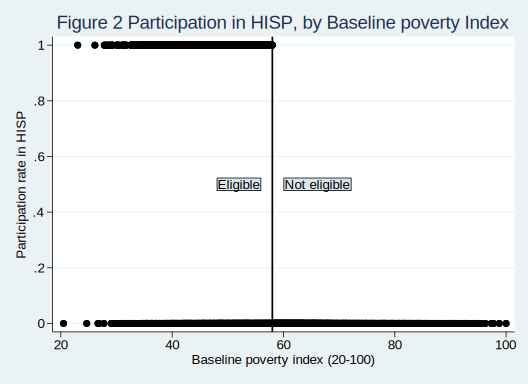

In [10]:
%%stata
graph twoway scatter enrolled poverty_index , title("Figure 2 Participation in HISP, by Baseline poverty Index") ylabel(, angle(horizontal)) ytitle("Participation rate in HISP") xtitle("Baseline poverty index (20-100)") xline(58, lcolor(black) lwidth(medthick))msize(medium) mcolor(black)text(.5 60 "Not eligible", placement(e) box)text(.5 56 "Eligible", placement(w) box)

## Step 2: Apply RDD

Now I process to apply the RDD methid to compute the impact of the program. Using follow-up data (treatment_locality == 1), I again plot the relationship between the scores on the poverty index and predicted health expenditures and find the relaotion illustrated in figure 3. 

In [11]:
%%capture
%%stata

# ssc install rdrobust 

# clone the running/ forcing variable (rv)
clonevar rv = poverty_index

# restrict the sample to the relevant locality
keep if treatment_locality == 1

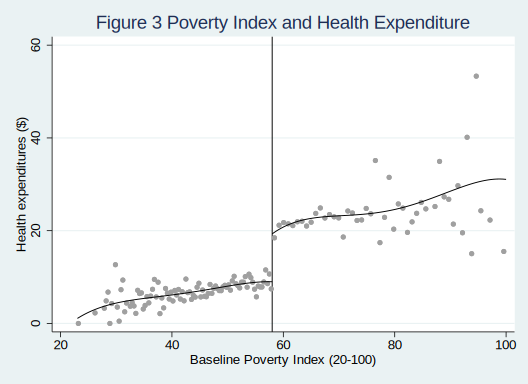

In [12]:
%%stata
qui rdplot y rv, c(58) lowerend(20) upperend(100) graph_options(title(Figure 3 Poverty Index and Health Expenditure) xtitle(Baseline Poverty Index (20-100)) ytitle(Health expenditures ($)) legend(off))

The discontinuity reflects a decrease in health expenditures for those househods eligible to receive the program. Given that households on both sides of the cutoff score of 58 are very similar, the plausible explanation for the different level of health expenditures is that one group of households was eligible to enroll in the program and the other was not. 

## Step 3: Set RDD Robustness Check
To make sure the running variable(poverty index) only react with our outcome(health expenditure). Here I plot a robustness check for the covariates(hospital_distance) against the running variables(health expenditure) to make sure they are not with RDD trends.The result in figure 4 shown that the covariates did not response to the running variable. 

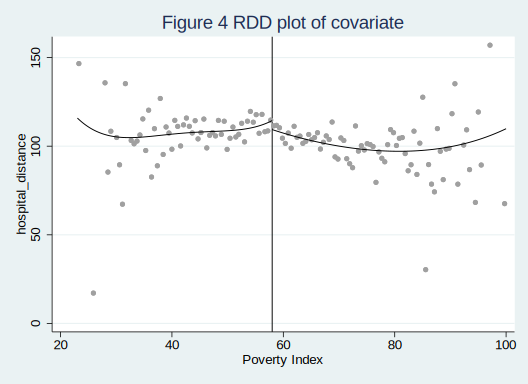

In [13]:
%%stata
qui rdplot hospital_distance rv, c(58) lowerend(20) upperend(100) graph_options(title(Figure 4 RDD plot of covariate) xtitle(Poverty Index) ytitle(hospital_distance) legend(off))

## Step 4: Estimate Treatment Effect

Now estimate the treatment effect using rdrobust

In [14]:
%%stata
rdrobust y rv $xs, c(58) h(10)


Sharp RD estimates using local polynomial regression.

     Cutoff c = 58 | Left of c  Right of c            Number of obs =       496
> 0
-------------------+----------------------            BW type       =     Manua
> l
     Number of obs |      2965        1995            Kernel        = Triangula
> r
Eff. Number of obs |      1887        1437            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |    10.000      10.000
       BW bias (b) |    10.000      10.000
         rho (h/b) |     1.000       1.000

Outcome: y. Running variable: rv.
-------------------------------------------------------------------------------
> -
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval
> ]
-------------------+-----------------------------------------------------------
> -
      Conventional |  10.689     .74145   14.4170  0.000    9.23627      12.142
> 7
            Robust |  

In [15]:
%%stata
rdrobust y rv $xs, c(58) h(10) kernel(uni)


Sharp RD estimates using local polynomial regression.

     Cutoff c = 58 | Left of c  Right of c            Number of obs =       496
> 0
-------------------+----------------------            BW type       =     Manua
> l
     Number of obs |      2965        1995            Kernel        =    Unifor
> m
Eff. Number of obs |      1887        1437            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |    10.000      10.000
       BW bias (b) |    10.000      10.000
         rho (h/b) |     1.000       1.000

Outcome: y. Running variable: rv.
-------------------------------------------------------------------------------
> -
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval
> ]
-------------------+-----------------------------------------------------------
> -
      Conventional |  10.799      .6872   15.7148  0.000     9.4523      12.146
> 1
            Robust |  

### Is the result shown valid for all eligible households?

No, the RDD estimates represent the effects for households very close to the cutoff poverty index score. Intuitively, this is the region where eligible and ineligible households have most similar characteristics and as such can be compared. 

### Compared with the impact estimated with the randomized assignment method, what does this result say about those households with a poverty index of just under 58?

This result says that households just under the poverty line have a slightly smaller reduction in health expenditures than the average eligible household (about $1 less). Households with a poverty index just under 58 will spend on average 9.03 less on health as a result of the HISP. This is less than the result in randomized assignment, which was an average decrease in health expenditures of 10.

### Based on the RDD impact estimates, should the HISP be scaled up nationally?

No, based on this result, the HISP should not be scaled up nationally because it decreased health expenditures by less than the $10 threshold level. 

# Additional Method

In [16]:
%%capture
%%stata
qui gen distance = rv-58
qui gen cutoff = distance > 0

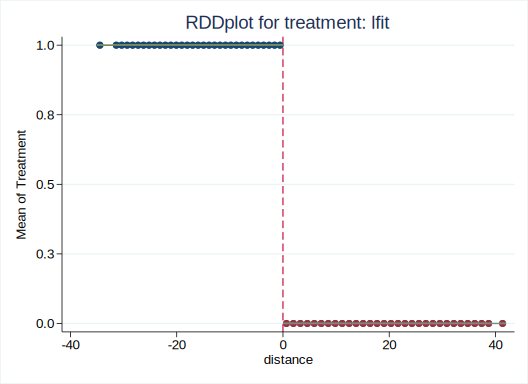

In [17]:
%%stata
qui cmogram d distance, cut(0) scatter line(0) lfitci graphopts( ytitle(Mean of Treatment) ylabel(, angle(horizontal)) title(RDDplot for treatment: lfit))

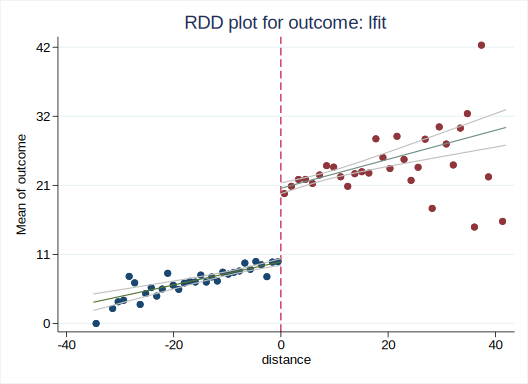

In [18]:
%%stata
qui cmogram y distance, cut(0) scatter line(0) lfitci graphopts(ytitle(Mean of outcome) ylabel(, angle(horizontal)) title(RDD plot for outcome: lfit))

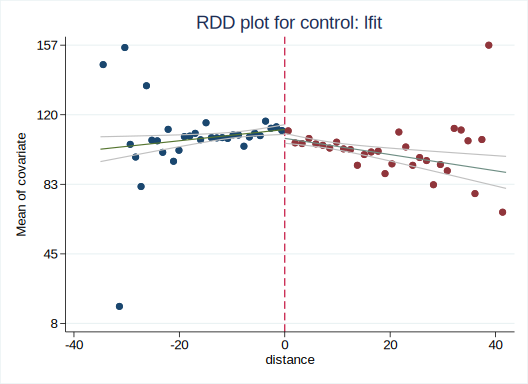

In [19]:
%%stata 
qui cmogram hospital_distance distance, cut(0) scatter line(0) lfitci graphopts(ytitle(Mean of covariate) ylabel(, angle(horizontal)) title(RDD plot for control: lfit))


. qui dstat density distance

. dstat graph, title(Manipulation of running variabls: density plot) subtitle(M
> cCrary test) xline(0, lcol(navy) lwidth(medium) lp(solid)) note($note) graphr
> egion(margin(r small))
(note:  named style sma not found in class gsize, default attributes used)

. 


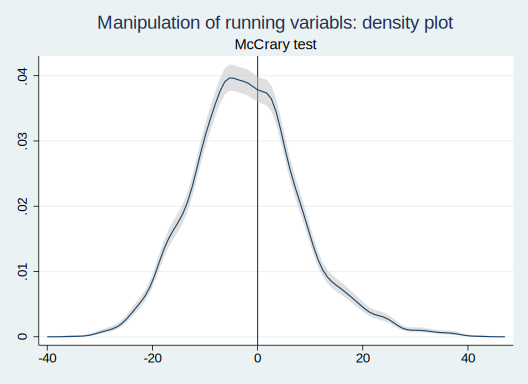

In [20]:
%%stata 
qui dstat density distance
dstat graph, title(Manipulation of running variabls: density plot) subtitle(McCrary test) xline(0, lcol(navy) lwidth(medium) lp(solid)) note($note) graphregion(margin(r small))